In [ ]:
!pip install yfinance
!pip install transformers
!pip install wandb
!pip install beautifulsoup4


In [1]:
import yfinance as yf
import datetime
import numpy as np
import pandas as pd
from pylab import mpl, plt
import itertools
from datetime import datetime
from operator import itemgetter
from tqdm import tqdm
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable
from transformers import RobertaTokenizer, RobertaModel
import torch.nn.functional as F
import wandb


In [2]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
wandb.login()
wandb.init(project="stock_prediction")

### Hyperparams

In [3]:
no_of_days_to_lookforward = 1
no_of_days_to_lookback = 5
up_threshold = 0.015
down_threshold = -0.015
max_text_per_iter = 20
batch_size = 32
MAX_LEN = 10
num_epochs = 50
save_freq_epoch = 10
run_id = str(53)
output_path = '/content/drive/MyDrive/machine_learning/projects/xai-seq/output/run_' + run_id
# !mkdir $output_path
# !mkdir /content/drive/MyDrive/machine_learning/projects/xai-seq/output/

# define sweepable hyperparams for wandb
sweep_configuration = {
    'method': 'random',
    'name': 'sweep',
    'metric': {'goal': 'maximize', 'name': 'test accuracy in this epoch'},
    'parameters': 
    {
        'lr': {'max': 0.01, 'min': 0.00001},
        'lstm_layers' : {'max': 8, 'min': 1},
        'lstm_dim': {'max': 30, 'min': 10 },
        'num_epochs': {'value': 50}
     }
}



In [4]:
sweep_id = wandb.sweep(
  sweep=sweep_configuration, 
  project='stock_prediction'
  )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: txibdbxx
Sweep URL: https://wandb.ai/visriv/stock_prediction/sweeps/txibdbxx


### Get stocks data for last N days

In [ ]:
!mkdir data


In [5]:
stock_symbols = [ 'XOM']
no_of_days = 4*365

EXPORT_DATA_FOLDER = './data/'
# !mkdir data
# Set the start and end dates for the data
# here matching it with dates of news text available
date_start = datetime.strptime('2017/01/01', '%Y/%m/%d')
date_train_end = datetime.strptime('2022/09/30', '%Y/%m/%d')
date_end = datetime.strptime('2023/07/01', '%Y/%m/%d')


# start = datetime.datetime.now() - datetime.timedelta(days=no_of_days)
# end = datetime.datetime.now()

# Get training data
for symbol in stock_symbols:
    # Download the historical price and volume data using yfinance
    all_data_raw = yf.download(symbol, start=date_start, end=date_end)

    # Raw signals
    open = all_data_raw['Open'].fillna(0)
    high = all_data_raw['High'].fillna(0)
    low = all_data_raw['Low'].fillna(0)
    close = all_data_raw['Close'].fillna(0)
    adjclose = all_data_raw['Adj Close'].fillna(0)
    volume = all_data_raw['Volume'].fillna(0)
    
    
    # Normalize features by percent of changes between today and yesterday
    pct_change_open = all_data_raw['Open'].pct_change().fillna(0)
    pct_change_high = all_data_raw['High'].pct_change().fillna(0)
    pct_change_high_over_open = (all_data_raw['High']-all_data_raw['Open'])/all_data_raw['Open']
    pct_change_low = all_data_raw['Low'].pct_change().fillna(0)
    pct_change_low_over_open = (all_data_raw['Low']-all_data_raw['Open'])/all_data_raw['Open']
    pct_change_close = all_data_raw['Close'].pct_change().fillna(0)
    pct_change_close_over_open = (all_data_raw['Close']-all_data_raw['Open'])/all_data_raw['Open']
    pct_change_adjclose = all_data_raw['Adj Close'].pct_change().fillna(0)
    pct_change_adjclose_over_open = (all_data_raw['Adj Close']-all_data_raw['Open'])/all_data_raw['Open']
    pct_change_volume = all_data_raw['Volume'].pct_change().fillna(0)

    # Prepare labels: 2 means the close price of tomorow is higher than today's close price; 1 is down; 0 means the movement is between up_threshold and down_threshold
    label = np.where(pct_change_close > up_threshold, 2, np.where(pct_change_close < down_threshold, 1, 0))[1:]
    label = np.append(label, 0)

    # Construct a train_data_norm data frame
    all_data_norm = pd.DataFrame({
                              'Open_abs': open,
                              'High_abs': high,
                              'Low_abs': low,
                              'Close_abs': close,
                              'AdjClose_abs': adjclose,
                              'Volume_abs': volume,
                              'Open_norm':pct_change_open,
                              'High_norm':pct_change_high,
                              'Low_norm': pct_change_low,
                              'Close_norm':pct_change_close,
                              'Volume_norm':pct_change_volume,
                              'High-Open_norm':pct_change_high_over_open,
                              'Low-Open_norm':pct_change_low_over_open,
                              'Close-Open_norm':pct_change_close_over_open,
                              'AdjClose_norm':pct_change_adjclose,
                              'AdjClose-Open_norm':pct_change_adjclose_over_open,        
                              'Label_2up1down':label})

    # Normalize by min-max normalization after the pct normalization
    all_data_norm['Open_abs'] = all_data_norm['Open_abs'].apply(lambda x: (x - all_data_norm['Open_abs'].min()) / (all_data_norm['Open_abs'].max() - all_data_norm['Open_abs'].min()))
    all_data_norm['High_abs'] = all_data_norm['High_abs'].apply(lambda x: (x - all_data_norm['High_abs'].min()) / (all_data_norm['High_abs'].max() - all_data_norm['High_abs'].min()))
    all_data_norm['Low_abs'] = all_data_norm['Low_abs'].apply(lambda x: (x - all_data_norm['Low_abs'].min()) / (all_data_norm['Low_abs'].max() - all_data_norm['Low_abs'].min()))
    all_data_norm['Close_abs'] = all_data_norm['Close_abs'].apply(lambda x: (x - all_data_norm['Close_abs'].min()) / (all_data_norm['Close_abs'].max() - all_data_norm['Close_abs'].min()))
    all_data_norm['AdjClose_abs'] = all_data_norm['AdjClose_abs'].apply(lambda x: (x - all_data_norm['AdjClose_abs'].min()) / (all_data_norm['AdjClose_abs'].max() - all_data_norm['AdjClose_abs'].min()))
    all_data_norm['Volume_abs'] = all_data_norm['Volume_abs'].apply(lambda x: (x - all_data_norm['Volume_abs'].min()) / (all_data_norm['Volume_abs'].max() - all_data_norm['Volume_abs'].min()))

    
    all_data_norm['Open_norm'] = all_data_norm['Open_norm'].apply(lambda x: (x - all_data_norm['Open_norm'].min()) / (all_data_norm['Open_norm'].max() - all_data_norm['Open_norm'].min()))
    all_data_norm['High_norm'] = all_data_norm['High_norm'].apply(lambda x: (x - all_data_norm['High_norm'].min()) / (all_data_norm['High_norm'].max() - all_data_norm['High_norm'].min()))
    all_data_norm['Low_norm'] = all_data_norm['Low_norm'].apply(lambda x: (x - all_data_norm['Low_norm'].min()) / (all_data_norm['Low_norm'].max() - all_data_norm['Low_norm'].min()))
    all_data_norm['Close_norm'] = all_data_norm['Close_norm'].apply(lambda x: (x - all_data_norm['Close_norm'].min()) / (all_data_norm['Close_norm'].max() - all_data_norm['Close_norm'].min()))
    all_data_norm['Volume_norm'] = all_data_norm['Volume_norm'].apply(lambda x: (x - all_data_norm['Volume_norm'].min()) / (all_data_norm['Volume_norm'].max() - all_data_norm['Volume_norm'].min()))
    all_data_norm['High-Open_norm'] = all_data_norm['High-Open_norm'].apply(lambda x: (x - all_data_norm['High-Open_norm'].min()) / (all_data_norm['High-Open_norm'].max() - all_data_norm['High-Open_norm'].min()))
    all_data_norm['Low-Open_norm'] = all_data_norm['Low-Open_norm'].apply(lambda x: (x - all_data_norm['Low-Open_norm'].min()) / (all_data_norm['Low-Open_norm'].max() - all_data_norm['Low-Open_norm'].min()))
    all_data_norm['Close-Open_norm'] = all_data_norm['Close-Open_norm'].apply(lambda x: (x - all_data_norm['Close-Open_norm'].min()) / (all_data_norm['Close-Open_norm'].max() - all_data_norm['Close-Open_norm'].min()))
    all_data_norm['AdjClose_norm'] = all_data_norm['AdjClose_norm'].apply(lambda x: (x - all_data_norm['AdjClose_norm'].min()) / (all_data_norm['AdjClose_norm'].max() - all_data_norm['AdjClose_norm'].min()))
    all_data_norm['AdjClose-Open_norm'] = all_data_norm['AdjClose-Open_norm'].apply(lambda x: (x - all_data_norm['AdjClose-Open_norm'].min()) / (all_data_norm['AdjClose-Open_norm'].max() - all_data_norm['AdjClose-Open_norm'].min()))

    # Remove the first and the last row, becuase of NAN values
    all_data_raw = all_data_raw.iloc[1:-1]
    all_data_norm = all_data_norm.iloc[1:-1]

    all_data_raw.to_csv(EXPORT_DATA_FOLDER+symbol+'all_data_raw.csv', index=True)
    all_data_norm.to_csv(EXPORT_DATA_FOLDER+symbol+'all_data_norm.csv', index=True)

train_data_raw = all_data_raw.loc[:date_train_end]
test_data_raw = all_data_raw.loc[date_train_end:]
train_data_norm = all_data_norm.loc[:date_train_end]
test_data_norm = all_data_norm.loc[date_train_end:]



[*********************100%***********************]  1 of 1 completed


In [ ]:
print(len(train_data_norm))
print(len(test_data_norm))

## TODO

In [ ]:
'''
(2023-06-05)
cuda support check
//read textual data into correct shape
hyperparam tuning: number of neurons: tune to right number of neurons in FC in model
//max_text_per_iter -> code in dataloader to maintain the size

(2023-06-07)
cuda check
roberta encoder fix
multi label - how to create target label?

'''

## Prep textual data

### Crawl textual news data from internet

In [ ]:
# Import libraries
from bs4 import BeautifulSoup
from urllib.request import urlopen
from urllib.request import Request
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Parameters
n = 3 #the # of article headlines displayed per ticker
tickers = ['AAPL', 'TSLA', 'AMZN']



# Get Data
finviz_url = 'https://finviz.com/quote.ashx?t='
news_tables = {}

for ticker in tickers:
    url = finviz_url + ticker
    req = Request(url=url,
                  headers={'user-agent': 'Mozilla/5.0',
                                   'referer': 'https://...'})
    resp = urlopen(req)
    html = BeautifulSoup(resp, features="lxml")
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

try:
    for ticker in tickers:
        df = news_tables[ticker]
        df_tr = df.findAll('tr')

        print ('\n')
        print ('Recent News Headlines for {}: '.format(ticker))

        for i, table_row in enumerate(df_tr):
            a_text = table_row.a.text
            td_text = table_row.td.text
            td_text = td_text.strip()
            print(a_text,'(',td_text,')')
            if i == n-1:
                break
except KeyError:
    pass


# Iterate through the news
parsed_news = []
for file_name, news_table in news_tables.items():
    for x in news_table.findAll('tr'):
        text = x.a.get_text()
        date_scrape = x.td.text.split()

        if len(date_scrape) == 1:
            time = date_scrape[0]

        else:
            date = date_scrape[0]
            time = date_scrape[1]

        ticker = file_name.split('_')[0]

        parsed_news.append([ticker, date, time, text])



### Read downloaded data from saved files

In [6]:
text_data_df = pd.read_csv('./data/XOM_20200401_20230401_medium (1).csv',
                           sep= ',',
                           header= 0,
                           engine='python',
                           on_bad_lines = 'skip')
text_data_df = text_data_df[['Date', 'News']]


text_data_df = text_data_df.groupby('Date')['News'].apply('$$$###'.join)

text_data_df.index = pd.to_datetime(text_data_df.index, dayfirst=True)
# text_data_df


In [7]:
all_train_df = train_data_norm.join(text_data_df, how = 'left')
all_test_df = test_data_norm.join(text_data_df, how = 'left')

print(all_train_df.index.min())
print(all_train_df.index.max())
print(all_test_df.index.min())
print(all_test_df.index.max())

2017-01-04 00:00:00
2022-09-30 00:00:00
2022-09-30 00:00:00
2023-06-29 00:00:00


array([[<Axes: title={'center': 'Open_abs'}>,
        <Axes: title={'center': 'High_abs'}>,
        <Axes: title={'center': 'Low_abs'}>,
        <Axes: title={'center': 'Close_abs'}>],
       [<Axes: title={'center': 'AdjClose_abs'}>,
        <Axes: title={'center': 'Volume_abs'}>,
        <Axes: title={'center': 'Open_norm'}>,
        <Axes: title={'center': 'High_norm'}>],
       [<Axes: title={'center': 'Low_norm'}>,
        <Axes: title={'center': 'Close_norm'}>,
        <Axes: title={'center': 'Volume_norm'}>,
        <Axes: title={'center': 'High-Open_norm'}>],
       [<Axes: title={'center': 'Low-Open_norm'}>,
        <Axes: title={'center': 'Close-Open_norm'}>,
        <Axes: title={'center': 'AdjClose_norm'}>,
        <Axes: title={'center': 'AdjClose-Open_norm'}>],
       [<Axes: title={'center': 'Label_2up1down'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

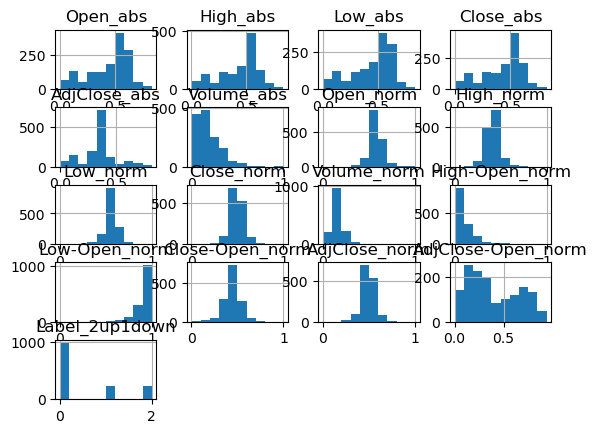

In [8]:
all_train_df.hist()

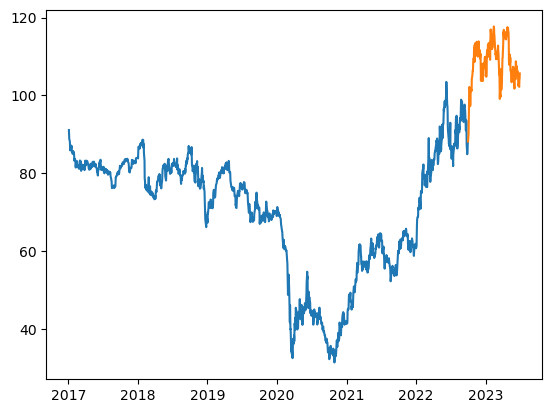

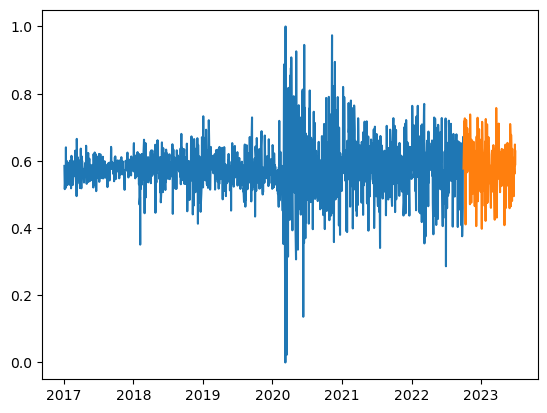

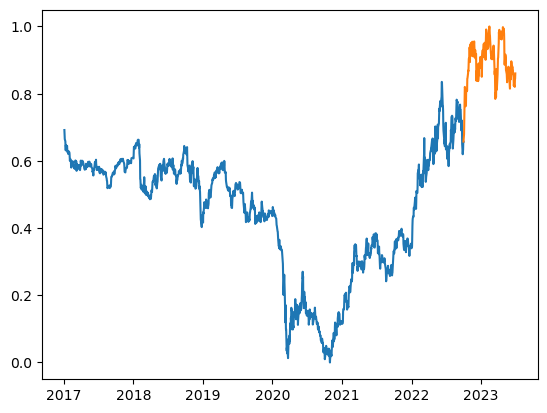

In [9]:
plt.plot(train_data_raw['Open'])
plt.plot(test_data_raw['Open'])
plt.show()
plt.plot(all_train_df['Open_norm'])
plt.plot(all_test_df['Open_norm'])
plt.show()
plt.plot(all_train_df['Open_abs'])
plt.plot(all_test_df['Open_abs'])
plt.show()

### Merge textual and numerical data


In [10]:
all_train = all_train_df.values

window_size = no_of_days_to_lookback

X_numerical_train = []
y_train = []
X_text_train = []
X_text_train_curr = []





for i in range(window_size, len(all_train) - no_of_days_to_lookforward + 1):
    X_numerical_train.append(all_train[i-window_size: i, :-2])

    # split and append sequence of text
    curr_seq = all_train[i-window_size: i, -1]
    for j in range(window_size):
        if (curr_seq[window_size - 1 -j] is not np.NaN):
            split_curr_seq = curr_seq[window_size - 1 -j].split('$$$###')
        else:
            split_curr_seq = []
        X_text_train_curr = X_text_train_curr + split_curr_seq

    if len(X_text_train_curr) > max_text_per_iter:
        X_text_train_curr = X_text_train_curr[:max_text_per_iter]

    X_text_train.append(X_text_train_curr)

    # target labels
    y_train.append(all_train[i:i+no_of_days_to_lookforward, -2])

X_numerical_train, y_train = np.array(X_numerical_train).astype(np.float16), np.array(y_train).astype(np.int32)
print(type(X_numerical_train))
print(type(y_train))

X_numerical_train = torch.from_numpy(X_numerical_train).type(torch.Tensor)
y_train = torch.from_numpy(y_train).long()

print(len(X_numerical_train))
print(len(X_text_train))
print(len(y_train))
print(X_numerical_train.shape)

print(len(X_text_train))
print(len(X_text_train[2]))
# print(X_text_train[2])


    
    
    
all_test = all_test_df.values
X_numerical_test = []
y_test = []
X_text_test = []
X_text_test_curr = []

for i in range(window_size, len(all_test) - no_of_days_to_lookforward + 1):
    X_numerical_test.append(all_test[i-window_size: i, :-2])

    # split and append sequence of text (in reverse order to add the latest news first)
    curr_seq = all_test[i-window_size: i, -1]
    for j in range(window_size):
        if (curr_seq[window_size - 1 -j] is not np.NaN):
            split_curr_seq = curr_seq[window_size - 1 -j].split('$$$###')
        else:
            split_curr_seq = []
        X_text_test_curr = X_text_test_curr + split_curr_seq

    if len(X_text_test_curr) > max_text_per_iter:
        X_text_test_curr = X_text_test_curr[:max_text_per_iter]

    X_text_test.append(X_text_test_curr)

    # target labels
    y_test.append(all_test[i:i+no_of_days_to_lookforward, -2])

X_numerical_test, y_test = np.array(X_numerical_test).astype(np.float16), np.array(y_test).astype(np.int32)
print(type(X_numerical_test))
print(type(y_test))

X_numerical_test = torch.from_numpy(X_numerical_test).type(torch.Tensor)
y_test = torch.from_numpy(y_test).long()

print(len(X_numerical_test))
print(len(X_text_test))
print(len(y_test))
print(X_numerical_test.shape)

print(len(X_text_test))
print(len(X_text_test[2]))
# print(X_text_test[2])



# return X_numerical_train, y_train, X_text_train, X_numerical_test, y_test, X_text_test

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
1441
1441
1441
torch.Size([1441, 5, 16])
1441
0
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
182
182
182
torch.Size([182, 5, 16])
182
20


## Data loader

In [11]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader


class SiameseDataloader(Dataset):

    def __init__(self, X_numerical_train, y_train, X_text_train, MAX_LEN, tokenizer):
        self.X_numerical_train = X_numerical_train
        self.X_text_train = X_text_train
        self.MAX_LEN = MAX_LEN
        self.tokenizer = tokenizer

    def __getitem__(self, index):


        input_ids = []
        attention_masks = []
        token_type_ids = []
        input_seq = []
        
        
#         for sent in X_text_train[index]:
#             encoded_sent = self.tokenizer.encode_plus(
#                 text=sent,
#                 add_special_tokens=True,        # Add `[CLS]` and `[SEP]` special tokens
#                 max_length=self.MAX_LEN,             # Choose max length to truncate/pad
#                 pad_to_max_length=True,         # Pad sentence to max length
#                 #return_attention_mask=True      # Return attention mask
#                 return_token_type_ids=True
#                 )
#             input_ids.append(encoded_sent.get('input_ids'))
#             attention_masks.append(encoded_sent.get('attention_mask'))
#             token_type_ids.append(encoded_sent.get('token_type_ids'))

#         # Convert lists to tensors
#         input_ids = torch.tensor(input_ids)
#         attention_masks = torch.tensor(attention_masks)
#         token_type_ids = torch.tensor(token_type_ids)


        return {
            'x_numerical': X_numerical_train[index],
#             'ids': torch.tensor(input_ids, dtype=torch.long),
#             'mask': torch.tensor(attention_masks, dtype=torch.long),
#             'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(y_train[index], dtype=torch.long)
        }





    def __len__(self):
        return len(self.X_numerical_train)

In [12]:
print(X_numerical_train.shape)
print(y_train.shape)
print(len(X_text_train))
print(X_numerical_test.shape)
print(y_test.shape)
print(len(X_text_test))


torch.Size([1441, 5, 16])
torch.Size([1441, 1])
1441
torch.Size([182, 5, 16])
torch.Size([182, 1])
182


In [ ]:
y_train

In [13]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-large', truncation=True, do_lower_case=True)
global X_numerical_train, y_train, X_text_train, X_numerical_test, y_test, X_text_test

train_set = SiameseDataloader(X_numerical_train, y_train, X_text_train, MAX_LEN, tokenizer)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)


test_set = SiameseDataloader(X_numerical_test, y_test, X_text_test, MAX_LEN, tokenizer)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


In [ ]:
def private_func():
    print(len(X_numerical_train))

private_func()

## Build model


### lstm1, lstm2, roberta, concat, lrelu


In [ ]:
import torch.nn as nn

class SiameseModel11(nn.Module):
    def __init__(self, input_dim1, input_dim2,
                 hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4,
                 num_layers1, num_layers2, output_dim1, output_dim2):
        super(SiameseModel11, self).__init__()
        self.input_dim1 = input_dim1
        self.input_dim2 = input_dim2
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.hidden_dim3 = hidden_dim3
        self.hidden_dim4 = hidden_dim4
        self.num_layers1 = num_layers1
        self.num_layers2 = num_layers2
        self.output_dim1 = output_dim1
        self.output_dim2 = output_dim2

        self.roberta = RobertaModel.from_pretrained("roberta-large").to(device)

        self.lstm1 = nn.LSTM(input_dim1, hidden_dim1, num_layers1, batch_first=True)
        self.lstm2 = nn.LSTM(input_dim2, hidden_dim2, num_layers2, batch_first=True)

        self.fc1 = nn.Linear(hidden_dim1, output_dim1)
        self.fc2 = nn.Linear(hidden_dim2, output_dim2)
        self.fc3 = nn.Linear(output_dim1+output_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, hidden_dim4)
        self.fc5 = nn.Linear(hidden_dim4, 3)
        self.lrelu = nn.LeakyReLU(0.1)



    def forward(self, x1, ids, masks, token_type_ids):
        #left tower with numerical features
        h_10 = Variable(torch.zeros(self.num_layers1, x1.size(0), self.hidden_dim1)).to(device)
        c_10 = Variable(torch.zeros(self.num_layers1, x1.size(0), self.hidden_dim1)).to(device)
        ula1, (h_out1, _) = self.lstm1(x1, (h_10, c_10))
        h_out1 = h_out1.view(-1, self.hidden_dim1)
        out1 = self.fc1(h_out1)


        # right tower with roberta on textual features
        batch_size_here = ids.shape[0]
        e2 = torch.zeros(batch_size_here, max_text_per_iter,1024).to(device)

        for k in range(ids.shape[1]):
            seq_ids = ids[:,k,:]
            seq_masks = masks[:,k,:]
            seq_token_type_ids = token_type_ids[:,k,:]

            e2k = self.roberta(input_ids= seq_ids, attention_mask=seq_masks, token_type_ids=seq_token_type_ids)
            # first 0 is for last_hidden_state: https://huggingface.co/docs/transformers/main/en/model_doc/roberta#transformers.RobertaModel.forward.returns:~:text=transformers.modeling_outputs.-,BaseModelOutputWithPoolingAndCrossAttentions%20or%20tuple(torch.FloatTensor),-A%20transformers.modeling_outputs
            # the shape of e2k[0] is (batch_size, sequence_length (<=MAX_LEN), hidden_size (=1024))
            e2k1 = e2k[0][:, 0, :]
            e2[:,k,:] = e2k1


        print(e2.shape)
        h_20 = Variable(torch.zeros(self.num_layers2, e2.size(0), self.hidden_dim2)).to(device)
        c_20 = Variable(torch.zeros(self.num_layers2, e2.size(0), self.hidden_dim2)).to(device)
        ula2, (h_out2, _) = self.lstm2(e2, (h_20, c_20))
        h_out2 = h_out2.view(-1, self.hidden_dim2)
        out2 = self.fc2(h_out2)

        # siamese merging layers
        output = torch.cat((out1, out2),1)
        output = self.lrelu(self.fc3(output))
        output = self.lrelu(self.fc4(output))


        output = self.fc5(output)
        return output


### fcn1, fcn2, roberta, concat, lrelu

In [ ]:
import torch.nn as nn

class SiameseModel11_fcn(nn.Module):
    def __init__(self, input_dim1, input_dim2,
                 hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, hidden_dim6):
        super(SiameseModel11_fcn, self).__init__()
        self.input_dim1 = input_dim1
        self.input_dim2 = input_dim2
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.hidden_dim3 = hidden_dim3
        self.hidden_dim4 = hidden_dim4
        self.hidden_dim5 = hidden_dim5
        self.hidden_dim6 = hidden_dim6


        self.roberta = RobertaModel.from_pretrained("roberta-large").to(device)


        self.fc11 = nn.Linear(input_dim1, hidden_dim1)
        self.fc12 = nn.Linear(hidden_dim1, hidden_dim2)

        self.fc21 = nn.Linear(input_dim2, hidden_dim3)
        self.fc22 = nn.Linear(hidden_dim3, hidden_dim4)

        self.fc31 = nn.Linear(hidden_dim2+hidden_dim4, hidden_dim5)
        self.fc32 = nn.Linear(hidden_dim5, hidden_dim6)
        self.fc33 = nn.Linear(hidden_dim6, 3)
        self.lrelu = nn.LeakyReLU(0.1)



    def forward(self, x1, ids, masks, token_type_ids):
        #left tower with numerical features

        batch_size, seq_len, embedding_size = x1.size()
        x1 = torch.reshape(x1, (batch_size, seq_len*embedding_size))

        out1 = self.fc11(x1)
        print('out1 shape:', out1.shape)

        out1 = self.fc12(out1)
        print('out1 shape:', out1.shape)

        # right tower with roberta on textual features
        batch_size_here = ids.shape[0]
        e2 = torch.zeros(batch_size_here, max_text_per_iter,1024).to(device)

        for k in range(ids.shape[1]):
            seq_ids = ids[:,k,:]
            seq_masks = masks[:,k,:]
            seq_token_type_ids = token_type_ids[:,k,:]

            e2k = self.roberta(input_ids= seq_ids, attention_mask=seq_masks, token_type_ids=seq_token_type_ids)
            # first 0 is for last_hidden_state: https://huggingface.co/docs/transformers/main/en/model_doc/roberta#transformers.RobertaModel.forward.returns:~:text=transformers.modeling_outputs.-,BaseModelOutputWithPoolingAndCrossAttentions%20or%20tuple(torch.FloatTensor),-A%20transformers.modeling_outputs
            # the shape of e2k[0] is (batch_size, sequence_length (<=MAX_LEN), hidden_size (=1024))
            e2k1 = e2k[0][:, 0, :]
            e2[:,k,:] = e2k1

        print(e2.shape)
        batch_size, seq_len, embedding_size = e2.size()
        e2 = torch.reshape(e2, (batch_size, seq_len*embedding_size))
        print(e2.shape)

        out2 = self.fc21(e2)
        print('out2 shape:', out2.shape)
        out2 = self.fc22(out2)
        print('out2 shape:', out2.shape)


        # siamese merging layers
        output = torch.cat((out1, out2),1)
        output = self.lrelu(self.fc31(output))
        output = self.lrelu(self.fc32(output))
        output = self.fc33(output)
        return output


### lstm1, mlp, relu

In [ ]:
import torch.nn as nn

class SiameseModel10(nn.Module):
    def __init__(self, input_dim1, input_dim2,
                 hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4,
                 num_layers1, num_layers2, output_dim1, output_dim2):
        super(SiameseModel10, self).__init__()
        self.input_dim1 = input_dim1
        self.input_dim2 = input_dim2
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.hidden_dim3 = hidden_dim3
        self.hidden_dim4 = hidden_dim4
        self.num_layers1 = num_layers1
        self.num_layers2 = num_layers2
        self.output_dim1 = output_dim1
        self.output_dim2 = output_dim2


        self.lstm1 = nn.LSTM(input_dim1, hidden_dim1, num_layers1, batch_first=True)

        self.fc1 = nn.Linear(hidden_dim1, output_dim1)
        self.fc3 = nn.Linear(output_dim1, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, hidden_dim4)
        self.fc5 = nn.Linear(hidden_dim4, 3)



    def forward(self, x1, ids, masks, token_type_ids):
        #left tower with numerical features
        h_10 = Variable(torch.zeros(self.num_layers1, x1.size(0), self.hidden_dim1)).to(device)
        c_10 = Variable(torch.zeros(self.num_layers1, x1.size(0), self.hidden_dim1)).to(device)
        ula1, (h_out1, _) = self.lstm1(x1, (h_10, c_10))
        h_out1 = h_out1.view(-1, self.hidden_dim1)
        out1 = self.fc1(h_out1)


        # mlp layers
        output = out1
        output = F.relu(self.fc3(output))
        output = F.relu(self.fc4(output))
        output = self.fc5(output)
        return output


### lstm1, mlp, lrelu

In [ ]:
import torch.nn as nn

class SiameseModel10leaky(nn.Module):
    def __init__(self, input_dim1,
                 hidden_dim1, hidden_dim3, hidden_dim4,
                 num_layers1, output_dim1):
        super(SiameseModel10leaky, self).__init__()
        self.input_dim1 = input_dim1
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim3 = hidden_dim3
        self.hidden_dim4 = hidden_dim4
        self.num_layers1 = num_layers1
        self.output_dim1 = output_dim1


        self.lstm1 = nn.LSTM(input_dim1, hidden_dim1, num_layers1, batch_first=True)

        self.fc1 = nn.Linear(hidden_dim1, output_dim1)
        self.fc3 = nn.Linear(output_dim1, hidden_dim3)
        # self.fc4 = nn.Linear(hidden_dim3, hidden_dim4)
        self.fc5 = nn.Linear(hidden_dim3, 3)
        self.lrelu = nn.LeakyReLU(0.1)



    def forward(self, x1):#, ids, masks, token_type_ids):
        #left tower with numerical features
        h_10 = Variable(torch.zeros(self.num_layers1, x1.size(0), self.hidden_dim1)).to(device)
        c_10 = Variable(torch.zeros(self.num_layers1, x1.size(0), self.hidden_dim1)).to(device)
        ula1, (h_out1, _) = self.lstm1(x1, (h_10, c_10))
#         print('h_out1 size', h_out1.shape)
#         h_out1 = h_out1.view(-1, self.hidden_dim1)
        ula1 = ula1[:, -1, :]
#         print('h_out1 size after view', ula1.shape)
        output = self.lrelu(self.fc1(ula1))


        # mlp layers
        output = self.lrelu(self.fc3(output))
        # output = self.lrelu(self.fc4(output))
        output = self.fc5(output)
        return output


### tranformer, mlp, relu


In [15]:
import torch.nn as nn
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=MAX_LEN):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        #pe.requires_grad = False
        self.register_buffer('pe', pe)
    def forward(self, x):
        return x + self.pe[:x.size(0), :]


class SiameseModel20(nn.Module):
    def __init__(self, input_dim1,
                 hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4,
                 num_layers1,  output_dim1,
                 nhead, d_transformer, dropout=0.2 ):
        super(SiameseModel20, self).__init__()

        self.input_dim1 = input_dim1
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.hidden_dim3 = hidden_dim3
        self.hidden_dim4 = hidden_dim4
        self.num_layers1 = num_layers1
        self.output_dim1 = output_dim1
        self.lrelu = nn.LeakyReLU(0.1)

        self.input_embedding  = nn.Linear(input_dim1, d_transformer)
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(d_model=d_transformer)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=d_transformer,
                                                        nhead=nhead,
                                                        dropout=dropout,
                                                        batch_first=True,
                                                        dim_feedforward = 24)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers1)


        # self.lstm1 = nn.LSTM(input_dim1, hidden_dim1, num_layers1, batch_first=True)


        self.fc1 = nn.Linear(5*d_transformer, output_dim1)
        self.fc3 = nn.Linear(output_dim1, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, hidden_dim4)
        self.fc5 = nn.Linear(hidden_dim4, 3)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.fc1.bias.data.zero_()
        self.fc1.weight.data.uniform_(-initrange, initrange)









    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, x1):#, ids, masks, token_type_ids):
        #left tower with numerical features
        # h_10 = Variable(torch.zeros(self.num_layers1, x1.size(0), self.hidden_dim1)).to(device)
        # c_10 = Variable(torch.zeros(self.num_layers1, x1.size(0), self.hidden_dim1)).to(device)
        # ula1, (h_out1, _) = self.lstm1(x1, (h_10, c_10))
        # h_out1 = h_out1.view(-1, self.hidden_dim1)
        # out1 = self.fc1(h_out1)

        #transformer encoder
        if self.src_mask is None or self.src_mask.size(0) != len(x1):
            device = x1.device
            mask = self._generate_square_subsequent_mask(len(x1)).to(device)
            self.src_mask = mask

        x1 = self.input_embedding(x1) # linear transformation before positional embedding

        x1 = self.pos_encoder(x1)
        output = self.transformer_encoder(x1, self.src_mask)#, self.src_mask)
        output = torch.flatten(output, start_dim=1)
        # output = output.view(-1, self.hidden_dim1)

        out1 = self.lrelu(self.fc1(output))


        # mlp  layers
        output = out1
        output = self.lrelu(self.fc3(output))
        output = self.lrelu(self.fc4(output))
        output = self.fc5(output)
        return output



### Choose a model

In [18]:
# model = SiameseModel11(input_dim1 = 8, input_dim2 = 1024,
#                        hidden_dim1 = 20, hidden_dim2 = 768, output_dim1 = 10, output_dim2 = 256,
#                        hidden_dim3 = 10, hidden_dim4 = 8,
#                        num_layers1 = 1, num_layers2 = 1, ).to(device)

# model = SiameseModel11_fcn(input_dim1 = 8*5, input_dim2 = 1024*20,
#                  hidden_dim1 = 20, hidden_dim2 = 10, hidden_dim3 = 768, hidden_dim4 = 256, hidden_dim5 = 128, hidden_dim6 = 64 ).to(device)

# model = SiameseModel10leaky(input_dim1 = 16,
#                  hidden_dim1 = 20, output_dim1 = 10, hidden_dim3 = 10, hidden_dim4 = 8,
#                  num_layers1 = 2).to(device)

model = SiameseModel20(input_dim1 = 16,
                 hidden_dim1 = 20, hidden_dim2 = 768, hidden_dim3 = 10, hidden_dim4 = 8,
                 num_layers1 = 1, output_dim1 = 10,  nhead = 4, d_transformer = 20, dropout = 0.2).to(device)

# model = SiameseModel10(input_dim1 = 8, input_dim2 = 1024,
#                  hidden_dim1 = 20, hidden_dim2 = 768, hidden_dim3 = 10, hidden_dim4 = 8,
#                  num_layers1 = 1, num_layers2 = 1, output_dim1 = 10, output_dim2 = 256).to(device)
# for param in model.roberta.parameters():
#     param.requires_grad = False
# print(model)

'''
SiameseModel10
SiameseModel10leaky
SiameseModel20
'''




'\nSiameseModel10\nSiameseModel10leaky\nSiameseModel20\n'

In [ ]:
model


In [19]:
for idx, data in tqdm(enumerate(train_loader, 0)):
    x_numerical = data['x_numerical'].to(device, dtype = torch.float)
#     ids = data['ids'].to(device, dtype = torch.long)
#     masks = data['mask'].to(device, dtype = torch.long)
#     token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
    targets = data['targets'].to(device, dtype = torch.long)


    y_pred = model(x_numerical)#, ids, masks, token_type_ids)
    print(y_pred)
    print(y_pred.size())


0it [00:00, ?it/s]/tmp/ipykernel_32187/3194931825.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'targets': torch.tensor(y_train[index], dtype=torch.long)
0it [00:00, ?it/s]


RuntimeError: The size of tensor a (32) must match the size of tensor b (10) at non-singleton dimension 0

## Train model

In [ ]:
def build_data_loader(MAX_LEN = 10):
#     global X_numerical_train, y_train, X_text_train, X_numerical_test, y_test, X_text_test
    
    tokenizer = RobertaTokenizer.from_pretrained('roberta-large', truncation=True, do_lower_case=True)

    
    train_set = SiameseDataloader(X_numerical_train, y_train, X_text_train, MAX_LEN, tokenizer)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)


    test_set = SiameseDataloader(X_numerical_test, y_test, X_text_test, MAX_LEN, tokenizer)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [ ]:
x,y = build_data_loader()
x

In [ ]:
def main(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config, project="stock_prediction"):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config
        
# def main():#train_loader, test_loader, device, num_epochs):
#     run = wandb.init(project="stock_prediction")
    

    
        # note that we define values from `wandb.config`  
        # instead of defining hard values
        lr  =  wandb.config.lr
        lstm_layers = wandb.config.lstm_layers
        lstm_dim = wandb.config.lstm_dim
        num_epochs = wandb.config.num_epochs
        device = 'cuda' if cuda.is_available() else 'cpu'
        
        
        train_loader, test_loader = build_data_loader()

            
            



        model = SiameseModel10leaky(input_dim1 = 16,
                     hidden_dim1 = lstm_dim, output_dim1 = 10, hidden_dim3 = 10, hidden_dim4 = 8,
                     num_layers1 = lstm_layers).to(device)

        criterion = nn.CrossEntropyLoss()
        optimiser = torch.optim.Adam(model.parameters(), lr=lr)
    #     loss_arr = np.zeros(num_epochs)


        train_loss_record = []
        # wandb.watch(model, log = 'all')
        for epoch in range(num_epochs):
            train_loss = []
            train_loss_sum = []
            train_correct = 0
            train_total = 0

            for idx, data in tqdm(enumerate(train_loader, 0)):
                x_numerical = data['x_numerical'].to(device, dtype = torch.float)
#                 ids = data['ids'].to(device, dtype = torch.long)
#                 masks = data['mask'].to(device, dtype = torch.long)
#                 token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
                targets = data['targets'].to(device, dtype = torch.long)




                y_pred = model(x_numerical)#, ids, masks, token_type_ids)
        #         print('y_pred shape', y_pred.shape)
        #         print('target shape', targets.reshape(-1).shape)
                _, pred_label = torch.max(y_pred.data, 1)

                loss = criterion(y_pred, targets.reshape(-1))

                 # Zero out gradient, else they will accumulate between epochs
                optimiser.zero_grad()

                # Backward pass
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

                for name, p in model.named_parameters():
                    if(p.requires_grad) and ("bias" not in name):
                        if p.grad is not None:
                            wandb.log({'gradient_' + name: p.grad.abs().mean().cpu().data.numpy()})
                        else:
                            wandb.log({'gradient_' + name: 0})


                # plot_grad_flow(model.named_parameters(), idx, epoch) # version 1

                # Update parameters
                optimiser.step()



                train_loss.append(loss.data.cpu())
                train_loss_sum.append(loss.data.cpu())


                wandb.log({'avg train loss in this batch': loss.item(), 'epoch': epoch, 'batch_id': idx})
                # Get accuracy
                train_total += targets.reshape(-1).size(0)
                train_correct += (pred_label == targets.reshape(-1)).sum()
            train_accuracy = 100 * train_correct / train_total

            # Record at every epoch
            print('Train Loss at epoch {}: {}\n'.format(epoch, np.mean(train_loss_sum)))
            train_loss_record.append(np.mean(train_loss_sum))
            wandb.log({'avg train loss in this epoch': np.mean(train_loss_sum)})
            wandb.log({'train accuracy in this epoch': train_accuracy})






            # evaluate on test set every epoch
            test_loss = []
            test_loss_sum = []

            correct = 0
            total = 0

            for idx, data in tqdm(enumerate(test_loader, 0)):
                test_x_numerical = data['x_numerical'].to(device, dtype = torch.float)
#                 test_ids = data['ids'].to(device, dtype = torch.long)
#                 test_masks = data['mask'].to(device, dtype = torch.long)
#                 test_token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
                test_targets = data['targets'].to(device, dtype = torch.long)

                y_pred = model(test_x_numerical)#, test_ids, test_masks, test_token_type_ids)
                _, pred_label = torch.max(y_pred.data, 1)

        #         print('y_pred:', y_pred)
                tloss = criterion(y_pred, test_targets.reshape(-1))

                test_loss.append(tloss.data.cpu())
                test_loss_sum.append(tloss.data.cpu())

                wandb.log({'avg test loss in this batch': tloss.item(),  'batch_id': idx})

                # Get accuracy
                total += test_targets.reshape(-1).size(0)
                correct += (pred_label == test_targets.reshape(-1)).sum()
            accuracy = 100 * correct / total

            # Record at every epoch
            print('test Loss at epoch {}: {}\n'.format(epoch, np.mean(test_loss_sum)))
            wandb.log({'avg test loss in this epoch': np.mean(test_loss_sum) })
            wandb.log({'test accuracy in this epoch': accuracy})












In [ ]:
wandb.agent(sweep_id, function=main, count=30)

## Save the model

In [ ]:
output_model_file = output_path + '/roberta_stock_pred.bin'
output_vocab_file = output_path

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)
